# KKBox Churn Prediction - Model Training with MLflow

This notebook trains three models (Logistic Regression, XGBoost, Random Forest) with hyperparameter tuning and comprehensive MLflow tracking.

**Key Features:**
- Separate encoding strategies for different model types
- RandomizedSearchCV for efficient hyperparameter tuning
- Class weight handling for imbalanced data
- Nested MLflow runs (parent per model, child per CV fold)
- Multiple evaluation metrics (ROC-AUC, Precision, Recall, F1)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import glob
import logging

In [3]:
# MLflow configuration
mlflow_tracking_uri = 'http://mlflow:5000'
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment("kkbox-churn-prediction")

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"MLflow Experiment: {mlflow.get_experiment_by_name('kkbox-churn-prediction').experiment_id}")

MLflow Tracking URI: http://mlflow:5000
MLflow Experiment: 1


## Timeline config

In [3]:
## Set up config (using your 4-split approach)
model_train_date_str = "2016-04-01"
train_period_months = 8
val_period_months = 2
test_period_months = 2
oot_period_months = 2

config = {}
config["model_train_date_str"] = model_train_date_str
config["model_train_date"] = datetime.strptime(model_train_date_str, "%Y-%m-%d")

# Work backwards from model_train_date
# OOT: Most recent data before deployment (2016-02-01 to 2016-03-31)
config["oot_end_date"] = config['model_train_date'] - timedelta(days=1)
config["oot_start_date"] = config['model_train_date'] - relativedelta(months=oot_period_months)

# Test: Before OOT (2015-12-01 to 2016-01-31)
config["test_end_date"] = config["oot_start_date"] - timedelta(days=1)
config["test_start_date"] = config["oot_start_date"] - relativedelta(months=test_period_months)

# Validation: Before Test (2015-10-01 to 2015-11-30)
config["val_end_date"] = config["test_start_date"] - timedelta(days=1)
config["val_start_date"] = config["test_start_date"] - relativedelta(months=val_period_months)

# Training: Before Validation (2015-02-01 to 2015-09-30)
config["train_end_date"] = config["val_start_date"] - timedelta(days=1)
config["train_start_date"] = config["val_start_date"] - relativedelta(months=train_period_months)

# NEW: Overall date range for extraction (covers all splits)
config["data_start_date"] = config["train_start_date"]  # Earliest date needed
config["data_end_date"] = config["oot_end_date"]        # Latest date needed

pprint.pprint(config)

{'data_end_date': datetime.datetime(2016, 3, 31, 0, 0),
 'data_start_date': datetime.datetime(2015, 2, 1, 0, 0),
 'model_train_date': datetime.datetime(2016, 4, 1, 0, 0),
 'model_train_date_str': '2016-04-01',
 'oot_end_date': datetime.datetime(2016, 3, 31, 0, 0),
 'oot_start_date': datetime.datetime(2016, 2, 1, 0, 0),
 'test_end_date': datetime.datetime(2016, 1, 31, 0, 0),
 'test_start_date': datetime.datetime(2015, 12, 1, 0, 0),
 'train_end_date': datetime.datetime(2015, 9, 30, 0, 0),
 'train_start_date': datetime.datetime(2015, 2, 1, 0, 0),
 'val_end_date': datetime.datetime(2015, 11, 30, 0, 0),
 'val_start_date': datetime.datetime(2015, 10, 1, 0, 0)}


## Load Data & Split

### Load data function

In [ ]:
def load_training_data(snapshot_date_str):
    spark = (
        SparkSession.builder
        .appName("kkbox_training_data_load")
        .master("local[*]")
        .getOrCreate()
    )
    spark.sparkContext.setLogLevel("WARN")

    snapshot_date = datetime.strptime(snapshot_date_str, "%Y-%m-%d").date()

    # ---------------------------
    # Load parquet data
    # ---------------------------
    features_path = "/app/datamart/gold/training_feature_store/"
    labels_path   = "/app/datamart/gold/training_label_store/"

    features_sdf = (
        spark.read.parquet(features_path)
                  .filter(
        (col("snapshot_date") >= F.lit(config["data_start_date"])) &
        (col("snapshot_date") <= F.lit(config["data_end_date"]))
    )
    )

    labels_sdf = (
        spark.read.parquet(labels_path)
                  .filter(
        (col("snapshot_date") >= F.lit(config["data_start_date"])) &
        (col("snapshot_date") <= F.lit(config["data_end_date"]))
    )
    )

    print("✅ Loaded feature rows:", features_sdf.count())
    print("✅ Loaded label rows:", labels_sdf.count())

    # ---------------------------
    # Join features + labels
    # ---------------------------
    full_sdf = (
        features_sdf
        .join(labels_sdf, ["msno", "snapshot_date"], "inner")
    )

    print("✅ Joined rows:", full_sdf.count())

    return spark, full_sdf


### Stratified sampling function

In [ ]:
def stratified_sample(full_sdf, label_col="is_churn", frac=0.3, seed=42):
    # Get distinct label values
    label_values = [row[label_col] for row in full_sdf.select(label_col).distinct().collect()]

    fractions = {int(v): frac for v in label_values}

    sample_sdf = full_sdf.sampleBy(label_col, fractions, seed)

    print("✅ Stratified sample rows:", sample_sdf.count())
    return sample_sdf

### Convert to Pandas DF

In [ ]:
def convert_to_pandas(sample_sdf):
    pdf = sample_sdf.toPandas()
    print("✅ Converted to pandas:", pdf.shape)
    return pdf


### Read, Join, Convert to Pandas DF

In [ ]:
# ---------------------------
# Load dataset from Spark
# ---------------------------
spark, training_sdf = load_training_data(snapshot_date_str)

# ---------------------------
# Stratified 30% sample
# ---------------------------
sample_sdf = stratified_sample(training_sdf, label_col="is_churn", frac=0.3)

# ---------------------------
# Convert to Pandas
# ---------------------------
data_pdf = convert_to_pandas(sample_sdf)

# ---------------------------
# Extract X, y for model training
# ---------------------------
feature_cols = [c for c in training_pdf.columns if c.startswith("fe_")]
X = training_pdf[feature_cols]
y = training_pdf["is_churn"]


### Split

In [5]:
# TIME-BASED SPLIT (NO SHUFFLING!) -- to prevent data leakages
feature_cols = ['tenure_days_at_snapshot',
                'registered_via',
                'city_clean', 
                'sum_secs_w30',
                'active_days_w30',
                'complete_rate_w30',
                'sum_secs_w7',
                'engagement_ratio_7_30',
                'days_since_last_play',
                'trend_secs_w30',
                'auto_renew_share',
                'last_is_auto_renew']

# Split data by time periods
train_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["train_start_date"].date()) & 
    (data_pdf['snapshot_date'] <= config["train_end_date"].date())
]

val_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["val_start_date"].date()) & 
    (data_pdf['snapshot_date'] <= config["val_end_date"].date())
]

test_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["test_start_date"].date()) & 
    (data_pdf['snapshot_date'] <= config["test_end_date"].date())
]

oot_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["oot_start_date"].date()) & 
    (data_pdf['snapshot_date'] <= config["oot_end_date"].date())
]

# Create X, y splits
X_train = train_pdf[feature_cols]
y_train = train_pdf["is_churn"]

X_val = val_pdf[feature_cols]
y_val = val_pdf["is_churn"]

X_test = test_pdf[feature_cols]
y_test = test_pdf["is_churn"]

X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["is_churn"]

# Verify splits
print("\n=== Data Split Summary ===")
print(f"Training:   {config['train_start_date'].date()} to {config['train_end_date'].date()} | {len(train_pdf):,} rows")
print(f"Validation: {config['val_start_date'].date()} to {config['val_end_date'].date()} | {len(val_pdf):,} rows")
print(f"Test:       {config['test_start_date'].date()} to {config['test_end_date'].date()} | {len(test_pdf):,} rows")
print(f"OOT:        {config['oot_start_date'].date()} to {config['oot_end_date'].date()} | {len(oot_pdf):,} rows")

print("\n=== Churn Rates ===")
print(f"Training:   {y_train.mean():.2%}")
print(f"Validation: {y_val.mean():.2%}")
print(f"Test:       {y_test.mean():.2%}")
print(f"OOT:        {y_oot.mean():.2%}")


=== Data Split Summary ===
Training:   2015-02-01 to 2015-09-30 | 1,430,517 rows
Validation: 2015-10-01 to 2015-11-30 | 447,007 rows
Test:       2015-12-01 to 2016-01-31 | 517,744 rows
OOT:        2016-02-01 to 2016-03-31 | 511,397 rows

=== Churn Rates ===
Training:   13.03%
Validation: 12.12%
Test:       20.12%
OOT:        18.48%


In [6]:
feature_cols = ['tenure_days_at_snapshot', 'registered_via', 'city_clean', 
                'sum_secs_w30', 'active_days_w30', 'complete_rate_w30', 
                'sum_secs_w7', 'engagement_ratio_7_30', 'days_since_last_play', 
                'trend_secs_w30', 'auto_renew_share', 'last_is_auto_renew']

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"OOT set shape: {X_oot.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set shape: (1430517, 12)
Validation set shape: (447007, 12)
Test set shape: (517744, 12)
OOT set shape: (511397, 12)

Class distribution in training set:
label
0    0.869677
1    0.130323
Name: proportion, dtype: float64


## Data Preparation: Handle Missing Values & Encoding

**Strategy**:
1. Create missing value indicators
2. Fill missing values with 0
3. One-hot encode for Logistic Regression (with scaling)
4. Keep original encoding for tree-based models

In [7]:
from sklearn.preprocessing import StandardScaler

# Identify categorical and numerical columns
categorical_cols = ['registered_via', 'city_clean']
numerical_cols = [col for col in feature_cols if col not in categorical_cols]

# Define feature groups for missing indicators
activity_features = ['sum_secs_w30', 'active_days_w30', 'complete_rate_w30', 
                     'sum_secs_w7', 'engagement_ratio_7_30', 'days_since_last_play', 
                     'trend_secs_w30']
demo_features = ['tenure_days_at_snapshot', 'registered_via', 'city_clean']

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['registered_via', 'city_clean']
Numerical columns: ['tenure_days_at_snapshot', 'sum_secs_w30', 'active_days_w30', 'complete_rate_w30', 'sum_secs_w7', 'engagement_ratio_7_30', 'days_since_last_play', 'trend_secs_w30', 'auto_renew_share', 'last_is_auto_renew']


### Step 1: Create Missing Value Indicators

In [8]:
print("\n[STEP 1] Creating missing value indicator features...")

# Create indicator features for ALL splits
for df in [X_train, X_val, X_test, X_oot]:
    # Indicator for missing activity features
    df['is_missing_activity'] = df['sum_secs_w30'].isnull().astype(int)
    
    # Indicator for missing demographic features
    df['is_missing_demo'] = df['tenure_days_at_snapshot'].isnull().astype(int)

print(f"  ✓ Created 'is_missing_activity' indicator")
print(f"  ✓ Created 'is_missing_demo' indicator")
print(f"  Train - Missing activity: {X_train['is_missing_activity'].sum():,} ({X_train['is_missing_activity'].mean():.1%})")
print(f"  Train - Missing demo: {X_train['is_missing_demo'].sum():,} ({X_train['is_missing_demo'].mean():.1%})")


[STEP 1] Creating missing value indicator features...
  ✓ Created 'is_missing_activity' indicator
  ✓ Created 'is_missing_demo' indicator
  Train - Missing activity: 268,550 (18.8%)
  Train - Missing demo: 140,268 (9.8%)


### Step 2: Fill Missing Values

In [9]:
print("\n[STEP 2] Filling missing values with 0...")

# Fill missing values with 0 (after creating indicators)
for df in [X_train, X_val, X_test, X_oot]:
    df.fillna(0, inplace=True)

print("  ✓ All missing values filled with 0")

# Verify no missing values remain
print(f"  Train missing values: {X_train.isnull().sum().sum()}")
print(f"  Val missing values: {X_val.isnull().sum().sum()}")
print(f"  Test missing values: {X_test.isnull().sum().sum()}")
print(f"  OOT missing values: {X_oot.isnull().sum().sum()}")


[STEP 2] Filling missing values with 0...
  ✓ All missing values filled with 0
  Train missing values: 0
  Val missing values: 0
  Test missing values: 0
  OOT missing values: 0


### Step 3: Prepare Data for Logistic Regression (One-Hot Encoding + Scaling)

In [10]:
print("\n[STEP 3] One-hot encoding categorical features for Logistic Regression...")

# Get dummies for registered_via and city_clean
X_train_lr = pd.get_dummies(X_train, columns=['registered_via', 'city_clean'], 
                             drop_first=True, dtype=int)
X_val_lr = pd.get_dummies(X_val, columns=['registered_via', 'city_clean'], 
                           drop_first=True, dtype=int)
X_test_lr = pd.get_dummies(X_test, columns=['registered_via', 'city_clean'], 
                            drop_first=True, dtype=int)
X_oot_lr = pd.get_dummies(X_oot, columns=['registered_via', 'city_clean'], 
                           drop_first=True, dtype=int)

# Align columns across all datasets (handle unseen categories)
all_columns = X_train_lr.columns
for df in [X_val_lr, X_test_lr, X_oot_lr]:
    # Add missing columns
    for col in all_columns:
        if col not in df.columns:
            df[col] = 0

# Reassign to ensure column alignment
X_val_lr = X_val_lr[all_columns]
X_test_lr = X_test_lr[all_columns]
X_oot_lr = X_oot_lr[all_columns]

print(f"  ✓ One-hot encoded 'registered_via' and 'city_clean'")
print(f"  ✓ Total features after encoding: {X_train_lr.shape[1]}")


[STEP 3] One-hot encoding categorical features for Logistic Regression...
  ✓ One-hot encoded 'registered_via' and 'city_clean'
  ✓ Total features after encoding: 37


### Step 4: Feature Scaling for Logistic Regression

In [11]:
print("\n[STEP 4] Scaling numeric features with StandardScaler...")

# Identify numeric columns (exclude one-hot encoded columns and binary indicators)
numeric_cols = [col for col in X_train_lr.columns 
                if not col.startswith('registered_via_') 
                and not col.startswith('city_clean_')
                and col not in ['is_missing_activity', 'is_missing_demo', 'last_is_auto_renew']]

print(f"  Scaling {len(numeric_cols)} numeric features: {numeric_cols}")

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
X_train_lr[numeric_cols] = scaler.fit_transform(X_train_lr[numeric_cols])

# Transform validation, test, and OOT using the same scaler
X_val_lr[numeric_cols] = scaler.transform(X_val_lr[numeric_cols])
X_test_lr[numeric_cols] = scaler.transform(X_test_lr[numeric_cols])
X_oot_lr[numeric_cols] = scaler.transform(X_oot_lr[numeric_cols])

print("  ✓ Features scaled (mean=0, std=1)")
print(f"  ✓ Logistic Regression data ready: {X_train_lr.shape}")


[STEP 4] Scaling numeric features with StandardScaler...
  Scaling 9 numeric features: ['tenure_days_at_snapshot', 'sum_secs_w30', 'active_days_w30', 'complete_rate_w30', 'sum_secs_w7', 'engagement_ratio_7_30', 'days_since_last_play', 'trend_secs_w30', 'auto_renew_share']
  ✓ Features scaled (mean=0, std=1)
  ✓ Logistic Regression data ready: (1430517, 37)


### Step 5: Prepare Data for Tree-Based Models (Original Encoding, No Scaling)

In [12]:
print("\n[STEP 5] Preparing data for tree-based models (XGBoost, Random Forest)...")

# For tree-based models, use the data after missing value handling but before one-hot encoding
# Tree models can handle label-encoded categoricals and don't need scaling
X_train_tree = X_train.copy()
X_val_tree = X_val.copy()
X_test_tree = X_test.copy()
X_oot_tree = X_oot.copy()

# Ensure categorical columns are integer type (safe now after fillna)
for col in categorical_cols:
    X_train_tree[col] = X_train_tree[col].astype(int)
    X_val_tree[col] = X_val_tree[col].astype(int)
    X_test_tree[col] = X_test_tree[col].astype(int)
    X_oot_tree[col] = X_oot_tree[col].astype(int)

print(f"  ✓ Tree-based model data ready: {X_train_tree.shape}")
print(f"  ✓ No scaling applied (tree models don't need it)")


[STEP 5] Preparing data for tree-based models (XGBoost, Random Forest)...
  ✓ Tree-based model data ready: (1430517, 14)
  ✓ No scaling applied (tree models don't need it)


## Utility Functions for Evaluation and Logging

In [13]:
def evaluate_model(model, X, y, dataset_name="", threshold=0.5):
    """
    Comprehensive model evaluation with multiple metrics.
    
    Args:
        model: Trained model
        X: Feature matrix
        y: True labels
        dataset_name: Name of dataset (train/val/test/oot)
        threshold: Classification threshold for precision/recall/F1
    
    Returns:
        Dictionary of metrics
    """
    # Get predictions
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    metrics = {
        f'{dataset_name}_roc_auc': roc_auc_score(y, y_pred_proba),
        f'{dataset_name}_precision': precision_score(y, y_pred, zero_division=0),
        f'{dataset_name}_recall': recall_score(y, y_pred, zero_division=0),
        f'{dataset_name}_f1': f1_score(y, y_pred, zero_division=0),
    }
    
    return metrics, y_pred_proba, y_pred


def plot_roc_curve(y_true, y_pred_proba, title="ROC Curve"):
    """
    Plot and return ROC curve figure.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    
    return fig


def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot and return confusion matrix figure.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)
    ax.set_xticklabels(['No Churn', 'Churn'])
    ax.set_yticklabels(['No Churn', 'Churn'])
    
    return fig

## Define Hyperparameter Search Spaces

In [14]:
# Logistic Regression hyperparameter space
lr_param_dist = {
    'C': uniform(0.01, 10),  # Regularization strength
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000, 3000]
}

# XGBoost hyperparameter space
xgb_param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 500),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Random Forest hyperparameter space
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Number of random parameter combinations to try
N_ITER = 50  # Adjust based on computational budget

print(f"Hyperparameter tuning configuration:")
print(f"  - CV folds: {cv.n_splits}")
print(f"  - Random search iterations: {N_ITER}")
print(f"  - Scoring metric: roc_auc")

Hyperparameter tuning configuration:
  - CV folds: 5
  - Random search iterations: 50
  - Scoring metric: roc_auc


## Model Training Pipeline

We'll create a reusable function that:
1. Performs RandomizedSearchCV with nested MLflow logging
2. Logs all hyperparameter combinations tried
3. Evaluates on all datasets (train, val, test, oot)
4. Creates and logs visualizations

In [15]:
def train_and_log_model(model_name, base_model, param_distributions, 
                        X_train, y_train, X_val, y_val, X_test, y_test, X_oot, y_oot,
                        n_iter=50, cv=5):
    """
    Train model with hyperparameter tuning and comprehensive MLflow logging.
    
    Args:
        model_name: Name of the model for MLflow tracking
        base_model: Scikit-learn estimator
        param_distributions: Dictionary of hyperparameter distributions
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        X_oot, y_oot: Out-of-time data
        n_iter: Number of random search iterations
        cv: Cross-validation strategy
    
    Returns:
        best_model: The best model from RandomizedSearchCV
    """
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}")
    
    # Start parent run
    with mlflow.start_run(run_name=f"{model_name}_hyperparameter_tuning"):
        
        # Log parent run metadata
        mlflow.set_tag("model_type", model_name)
        mlflow.set_tag("tuning_method", "RandomizedSearchCV")
        mlflow.log_param("n_iter", n_iter)
        mlflow.log_param("cv_folds", cv.n_splits if hasattr(cv, 'n_splits') else cv)
        mlflow.log_param("random_state", RANDOM_STATE)
        mlflow.log_param("train_samples", len(y_train))
        mlflow.log_param("val_samples", len(y_val))
        mlflow.log_param("test_samples", len(y_test))
        mlflow.log_param("oot_samples", len(y_oot))
        
        # Perform RandomizedSearchCV
        print(f"\n[INFO] Starting RandomizedSearchCV with {n_iter} iterations...")
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1,
            random_state=RANDOM_STATE,
            return_train_score=True
        )
        
        random_search.fit(X_train, y_train)
        
        print(f"\n[INFO] Best CV ROC-AUC: {random_search.best_score_:.4f}")
        print(f"[INFO] Best parameters: {random_search.best_params_}")
        
        # Log best parameters
        for param_name, param_value in random_search.best_params_.items():
            mlflow.log_param(f"best_{param_name}", param_value)
        
        mlflow.log_metric("best_cv_roc_auc", random_search.best_score_)
        
        # Log all CV results as child runs
        print(f"\n[INFO] Logging individual hyperparameter combinations...")
        cv_results = pd.DataFrame(random_search.cv_results_)
        
        for idx in range(min(10, len(cv_results))):  # Log top 10 combinations
            with mlflow.start_run(run_name=f"{model_name}_trial_{idx+1}", nested=True):
                # Log parameters for this trial
                params = cv_results.loc[idx, 'params']
                for param_name, param_value in params.items():
                    mlflow.log_param(param_name, param_value)
                
                # Log CV metrics
                mlflow.log_metric("mean_cv_roc_auc", cv_results.loc[idx, 'mean_test_score'])
                mlflow.log_metric("std_cv_roc_auc", cv_results.loc[idx, 'std_test_score'])
                mlflow.log_metric("mean_train_roc_auc", cv_results.loc[idx, 'mean_train_score'])
                mlflow.log_metric("rank", cv_results.loc[idx, 'rank_test_score'])
        
        # Get best model
        best_model = random_search.best_estimator_
        
        # Evaluate on all datasets
        print(f"\n[INFO] Evaluating best model on all datasets...")
        
        # Training set
        train_metrics, train_proba, train_pred = evaluate_model(
            best_model, X_train, y_train, dataset_name="train"
        )
        
        # Validation set
        val_metrics, val_proba, val_pred = evaluate_model(
            best_model, X_val, y_val, dataset_name="val"
        )
        
        # Test set
        test_metrics, test_proba, test_pred = evaluate_model(
            best_model, X_test, y_test, dataset_name="test"
        )
        
        # OOT set
        oot_metrics, oot_proba, oot_pred = evaluate_model(
            best_model, X_oot, y_oot, dataset_name="oot"
        )
        
        # Log all metrics
        all_metrics = {**train_metrics, **val_metrics, **test_metrics, **oot_metrics}
        for metric_name, metric_value in all_metrics.items():
            mlflow.log_metric(metric_name, metric_value)
        
        # Print results
        print(f"\n[RESULTS] {model_name} Performance:")
        print(f"  Train ROC-AUC: {train_metrics['train_roc_auc']:.4f}")
        print(f"  Val   ROC-AUC: {val_metrics['val_roc_auc']:.4f}")
        print(f"  Test  ROC-AUC: {test_metrics['test_roc_auc']:.4f}")
        print(f"  OOT   ROC-AUC: {oot_metrics['oot_roc_auc']:.4f}")
        
        # Create and log visualizations
        print(f"\n[INFO] Creating visualizations...")
        
        # ROC curves for each dataset
        for dataset_name, y_true, y_proba in [
            ('train', y_train, train_proba),
            ('val', y_val, val_proba),
            ('test', y_test, test_proba),
            ('oot', y_oot, oot_proba)
        ]:
            fig = plot_roc_curve(y_true, y_proba, title=f"{model_name} - {dataset_name.upper()} ROC Curve")
            mlflow.log_figure(fig, f"roc_curve_{dataset_name}.png")
            plt.close(fig)
        
        # Confusion matrices for validation and test sets
        for dataset_name, y_true, y_pred in [
            ('val', y_val, val_pred),
            ('test', y_test, test_pred),
            ('oot', y_oot, oot_pred)
        ]:
            fig = plot_confusion_matrix(y_true, y_pred, 
                                       title=f"{model_name} - {dataset_name.upper()} Confusion Matrix")
            mlflow.log_figure(fig, f"confusion_matrix_{dataset_name}.png")
            plt.close(fig)
        
        # Log model
        print(f"\n[INFO] Logging model to MLflow...")
        mlflow.sklearn.log_model(best_model, f"{model_name}_model")

        # --- Register best model to MLflow Model Registry ---
        run_id = mlflow.active_run().info.run_id
        model_uri = f"runs:/{run_id}/{model_name}_model"

        try:
            result = mlflow.register_model(
                model_uri=model_uri,
                name=model_name
            )
            print(f"✅ Registered model: {model_name} (version={result.version})")

        except Exception as e:
            print(f"⚠️ Model registration failed: {e}")

        
        # Log CV results dataframe
        cv_results_path = f"/tmp/{model_name}_cv_results.csv"
        cv_results.to_csv(cv_results_path, index=False)
        mlflow.log_artifact(cv_results_path, "cv_results")
        
        print(f"\n[SUCCESS] {model_name} training complete!")
        
    return best_model, all_metrics

## 1. Train Logistic Regression (with One-Hot Encoding)

In [16]:
# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(0.5749259698670833), 1: np.float64(3.8366268123521556)}


In [17]:
# Initialize Logistic Regression with class weights
lr_base = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train with hyperparameter tuning
lr_model, lr_metrics = train_and_log_model(
    model_name="LogisticRegression",
    base_model=lr_base,
    param_distributions=lr_param_dist,
    X_train=X_train_lr,
    y_train=y_train,
    X_val=X_val_lr,
    y_val=y_val,
    X_test=X_test_lr,
    y_test=y_test,
    X_oot=X_oot_lr,
    y_oot=y_oot,
    n_iter=N_ITER,
    cv=cv
)


Training LogisticRegression


2025/11/04 10:44:46 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet




[INFO] Starting RandomizedSearchCV with 50 iterations...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  


[INFO] Best CV ROC-AUC: 0.7954
[INFO] Best parameters: {'C': np.float64(0.4766566321361543), 'max_iter': 3000, 'penalty': 'l2', 'solver': 'saga'}

[INFO] Logging individual hyperparameter combinations...
🏃 View run LogisticRegression_trial_1 at: http://mlflow:5000/#/experiments/2/runs/1e48ad353fcd467b925aba2bea4f76ff
🧪 View experiment at: http://mlflow:5000/#/experiments/2
🏃 View run LogisticRegression_trial_2 at: http://mlflow:5000/#/experiments/2/runs/21af6e927c504f14a9b1a36258014099
🧪 View experiment at: http://mlflow:5000/#/experiments/2
🏃 View run LogisticRegression_trial_3 at: http://mlflow:5000/#/experiments/2/runs/5f335a120cc044399d2cffdde6670652
🧪 View experiment at: http://mlflow:5000/#/experiments/2
🏃 View run LogisticRegression_trial_4 at: http://mlflow:5000/#/experiments/2/runs/aec3cf7d00784cedad0bbf86601d77cb
🧪 View experiment at: http://mlflow:5000/#/experiments/2
🏃 View run LogisticRegression_trial_5 at: http://mlflow:5000/#/experiments/2/runs/fce15f9fe8da43cf80f0a1669

2025/11/04 14:50:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



[INFO] Logging model to MLflow...


2025/11/04 14:50:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



[SUCCESS] LogisticRegression training complete!
🏃 View run LogisticRegression_hyperparameter_tuning at: http://mlflow:5000/#/experiments/2/runs/557da1e1aaf44ea6a3b67e12bd9cc90a
🧪 View experiment at: http://mlflow:5000/#/experiments/2


In [5]:
run_id = "557da1e1aaf44ea6a3b67e12bd9cc90a"
model_name = "LogisticRegression"   # or any registry name you want

model_uri = f"runs:/{run_id}/LogisticRegression_model"

result = mlflow.register_model(
    model_uri=model_uri,
    name=model_name
)

print("✅ Model registered!")
print("Model name:", result.name)
print("Version:", result.version)

Successfully registered model 'LogisticRegression'.


RestException: RESOURCE_DOES_NOT_EXIST: Run with id=557da1e1aaf44ea6a3b67e12bd9cc90a not found

## 2. Train XGBoost (with Label Encoding)

In [18]:
# Calculate scale_pos_weight for XGBoost (handles class imbalance)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"XGBoost scale_pos_weight: {scale_pos_weight:.2f}")

XGBoost scale_pos_weight: 6.67


In [19]:
# Initialize XGBoost
xgb_base = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    use_label_encoder=False,
    n_jobs=-1
)

# Train with hyperparameter tuning
xgb_model, xgb_metrics = train_and_log_model(
    model_name="XGBoost",
    base_model=xgb_base,
    param_distributions=xgb_param_dist,
    X_train=X_train_tree,
    y_train=y_train,
    X_val=X_val_tree,
    y_val=y_val,
    X_test=X_test_tree,
    y_test=y_test,
    X_oot=X_oot_tree,
    y_oot=y_oot,
    n_iter=N_ITER,
    cv=cv
)


Training XGBoost

[INFO] Starting RandomizedSearchCV with 50 iterations...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:51:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:51:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:51:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:51:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:51:07] WARNING: /w


[INFO] Best CV ROC-AUC: 0.8171
[INFO] Best parameters: {'colsample_bytree': np.float64(0.7367518666865607), 'gamma': np.float64(0.4589953290672094), 'learning_rate': np.float64(0.03824709648056803), 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 303, 'reg_alpha': np.float64(0.017161101831750236), 'reg_lambda': np.float64(0.7633644230039109), 'subsample': np.float64(0.9227651908203118)}

[INFO] Logging individual hyperparameter combinations...
🏃 View run XGBoost_trial_1 at: http://mlflow:5000/#/experiments/2/runs/076a231a27f940dbb99d1fc0293081f1
🧪 View experiment at: http://mlflow:5000/#/experiments/2
🏃 View run XGBoost_trial_2 at: http://mlflow:5000/#/experiments/2/runs/41feead6178146e2840911c1d35f9712
🧪 View experiment at: http://mlflow:5000/#/experiments/2
🏃 View run XGBoost_trial_3 at: http://mlflow:5000/#/experiments/2/runs/58186442ffbe4a5d893b4f2dbafd5eec
🧪 View experiment at: http://mlflow:5000/#/experiments/2
🏃 View run XGBoost_trial_4 at: http://mlflow:5000/#/experimen

2025/11/04 15:41:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



[INFO] Logging model to MLflow...


2025/11/04 15:41:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



[SUCCESS] XGBoost training complete!
🏃 View run XGBoost_hyperparameter_tuning at: http://mlflow:5000/#/experiments/2/runs/b671460121d2442ea810a7515f60201c
🧪 View experiment at: http://mlflow:5000/#/experiments/2


In [4]:
run_id = "b671460121d2442ea810a7515f60201c"
model_name = "XGBoost"   # or any registry name you want

model_uri = f"runs:/{run_id}/XGBoost_model"

result = mlflow.register_model(
    model_uri=model_uri,
    name=model_name
)

print("✅ Model registered!")
print("Model name:", result.name)
print("Version:", result.version)

Successfully registered model 'XGBoost'.


RestException: RESOURCE_DOES_NOT_EXIST: Run with id=b671460121d2442ea810a7515f60201c not found

## 3. Train Random Forest (with Label Encoding)

In [29]:
# Initialize Random Forest with class weights
rf_base = RandomForestClassifier(
    class_weight=class_weight_dict,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train with hyperparameter tuning
rf_model, rf_metrics = train_and_log_model(
    model_name="RandomForest",
    base_model=rf_base,
    param_distributions=rf_param_dist,
    X_train=X_train_tree,
    y_train=y_train,
    X_val=X_val_tree,
    y_val=y_val,
    X_test=X_test_tree,
    y_test=y_test,
    X_oot=X_oot_tree,
    y_oot=y_oot,
    n_iter=1,
    cv=cv
)


Training RandomForest

[INFO] Starting RandomizedSearchCV with 1 iterations...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

[INFO] Best CV ROC-AUC: 0.8157
[INFO] Best parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 221}

[INFO] Logging individual hyperparameter combinations...
🏃 View run RandomForest_trial_1 at: http://mlflow:5000/#/experiments/2/runs/1659446ef42144e28ce92abd624513a0
🧪 View experiment at: http://mlflow:5000/#/experiments/2

[INFO] Evaluating best model on all datasets...

[RESULTS] RandomForest Performance:
  Train ROC-AUC: 0.8370
  Val   ROC-AUC: 0.7584
  Test  ROC-AUC: 0.6717
  OOT   ROC-AUC: 0.6295

[INFO] Creating visualizations...


2025/11/05 01:35:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



[INFO] Logging model to MLflow...


2025/11/05 01:35:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



[SUCCESS] RandomForest training complete!
🏃 View run RandomForest_hyperparameter_tuning at: http://mlflow:5000/#/experiments/2/runs/3a6ba11e0b714ad8aef626951841685c
🧪 View experiment at: http://mlflow:5000/#/experiments/2


In [6]:
run_id = "3a6ba11e0b714ad8aef626951841685c"
model_name = "RandomForest"   # or any registry name you want

model_uri = f"runs:/{run_id}/RandomForest_model"

result = mlflow.register_model(
    model_uri=model_uri,
    name=model_name
)

print("✅ Model registered!")
print("Model name:", result.name)
print("Version:", result.version)

Successfully registered model 'RandomForest'.


RestException: RESOURCE_DOES_NOT_EXIST: Run with id=3a6ba11e0b714ad8aef626951841685c not found

## Model Comparison

In [25]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Train ROC-AUC': [
        lr_metrics['train_roc_auc']
        ,xgb_metrics['train_roc_auc']
        #,rf_metrics['train_roc_auc']
    ],
    'Val ROC-AUC': [
        lr_metrics['val_roc_auc']
        ,xgb_metrics['val_roc_auc']
        #,rf_metrics['val_roc_auc']
    ],
    'Test ROC-AUC': [
        lr_metrics['test_roc_auc']
        ,xgb_metrics['test_roc_auc']
        # ,rf_metrics['test_roc_auc']
    ],
    'OOT ROC-AUC': [
        lr_metrics['oot_roc_auc']
        ,xgb_metrics['oot_roc_auc']
        #,rf_metrics['oot_roc_auc']
    ],
    'Test F1': [
        lr_metrics['test_f1']
        ,xgb_metrics['test_f1']
        #,rf_metrics['test_f1']
    ]
})

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Identify best model
best_model_idx = comparison_df['Test ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model (by Test ROC-AUC): {best_model_name}")
print(f"   Test ROC-AUC: {comparison_df.loc[best_model_idx, 'Test ROC-AUC']:.4f}")


FINAL MODEL COMPARISON
              Model  Train ROC-AUC  Val ROC-AUC  Test ROC-AUC  OOT ROC-AUC  Test F1
Logistic Regression       0.795488     0.752211      0.694169     0.690988 0.447000
            XGBoost       0.829568     0.752483      0.664833     0.627688 0.415794

🏆 Best Model (by Test ROC-AUC): Logistic Regression
   Test ROC-AUC: 0.6942


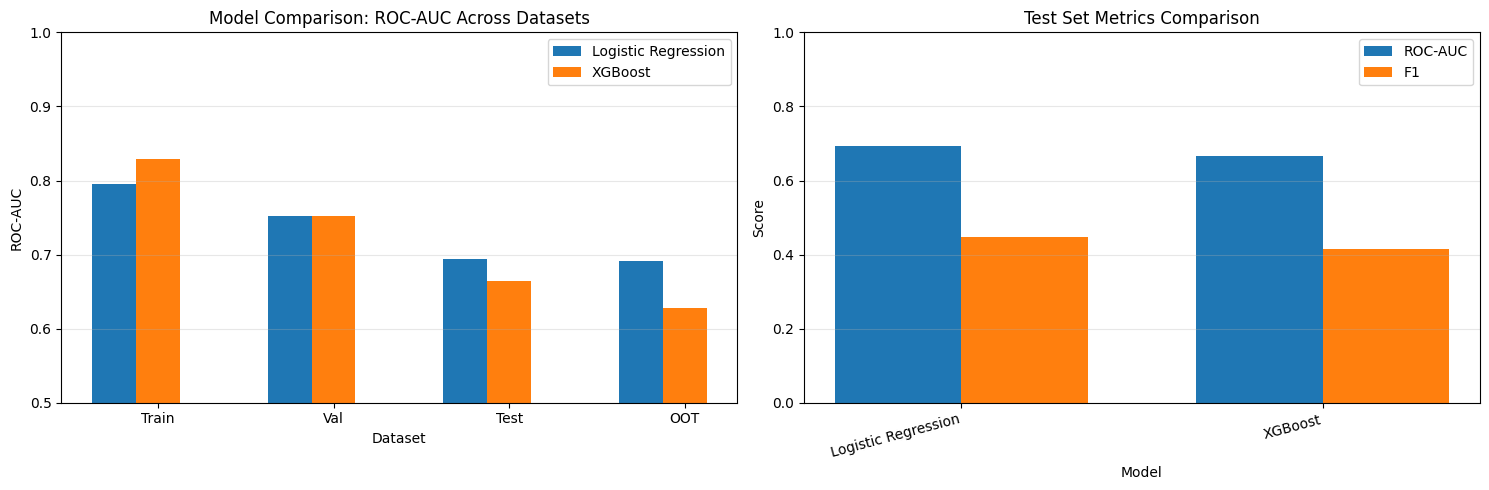

🏃 View run Model_Comparison_Summary at: http://mlflow:5000/#/experiments/2/runs/a478009e73b84e928112ba999bc708f8
🧪 View experiment at: http://mlflow:5000/#/experiments/2

✅ Model comparison logged to MLflow!


In [26]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC-AUC comparison across datasets
datasets = ['Train', 'Val', 'Test', 'OOT']
x = np.arange(len(datasets))
width = 0.25

axes[0].bar(x - width, comparison_df.iloc[:, 1:5].iloc[0], width, label='Logistic Regression')
axes[0].bar(x, comparison_df.iloc[:, 1:5].iloc[1], width, label='XGBoost')
#axes[0].bar(x + width, comparison_df.iloc[:, 1:5].iloc[2], width, label='Random Forest')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('Model Comparison: ROC-AUC Across Datasets')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Test set metrics comparison
test_metrics_data = {
    'ROC-AUC': comparison_df['Test ROC-AUC'].values,
    'F1': comparison_df['Test F1'].values
}
x = np.arange(len(comparison_df))
width = 0.35

axes[1].bar(x - width/2, test_metrics_data['ROC-AUC'], width, label='ROC-AUC')
axes[1].bar(x + width/2, test_metrics_data['F1'], width, label='F1')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score')
axes[1].set_title('Test Set Metrics Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('/tmp/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Log comparison to MLflow
with mlflow.start_run(run_name="Model_Comparison_Summary"):
    mlflow.log_figure(fig, "model_comparison.png")
    comparison_df.to_csv('/tmp/model_comparison.csv', index=False)
    mlflow.log_artifact('/tmp/model_comparison.csv')
    mlflow.log_metric("best_test_roc_auc", comparison_df['Test ROC-AUC'].max())
    mlflow.set_tag("best_model", best_model_name)

print("\n✅ Model comparison logged to MLflow!")

## Next Steps

1. **Review MLflow UI**: Open `http://mlflow:5000` to explore:
   - All hyperparameter combinations tried
   - Metrics across different datasets
   - Model artifacts and visualizations

2. **Model Selection**: Based on the comparison above, select your best model for production

3. **Model Registry**: Register the best model in MLflow Model Registry:
   ```python
   # Example:
   model_uri = f"runs:/<run_id>/XGBoost_model"
   mlflow.register_model(model_uri, "kkbox-churn-predictor")
   ```

4. **Further Tuning**: If needed:
   - Increase `N_ITER` for more thorough search
   - Try different threshold values for precision/recall trade-off
   - Perform feature engineering based on model insights
   - Consider ensemble methods